In [1]:
import io
import os
import pickle
import random as rn
import warnings
from multiprocessing import cpu_count

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from gensim.models import Word2Vec
from IPython.display import display
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, \
        average_precision_score, ndcg_score, \
        label_ranking_average_precision_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant, GlorotUniform
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, \
        GlobalMaxPooling1D, SpatialDropout1D, LSTM, GRU, Flatten, MaxPooling1D, \
        BatchNormalization, ReLU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import data
import preprocessing

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)

## Extracting the data

In [2]:
# data.extract_data(extraction_dir="train",
#                   data_dir="data",
#                   data_zip_name="reuters-training-corpus.zip")

train_df = pd.read_pickle("train/data.pkl")

# train_df = data.get_docs_labels("train/REUTERS_CORPUS_2")
# train_df.to_pickle("train/data.pkl")

train_docs = train_df["doc"].values
train_labels = np.array(train_df["labels"].tolist())
n_labels = len(data.CODEMAP)

print(train_docs.shape)
print(train_labels.shape)
print(train_docs[2])
print(train_labels[2])

(299773,)
(299773, 126)
Toronto stocks end higher after volatile session. CHANGE				    CHANGE TSE	  5900.37    +50.15   HI 5900.37	    LO  5840.29 DJI	  6611.05    +27.57   GOLD (LONDON)   US$350.00 +1.90 FTSE100    4248.10    -64.80   GOLD (NY-COMEX) US$354.80 +0.70 NIKKEI    17869.59   -133.81   LME CASH NICKEL US$7659   +99.0 CANDLR	1.3883		 LME CASH ALUM   US$1602.0  -4.0 CAN 30-YR   107.41     -0.15   BRENT CRUDE     US$19.09  -0.27 --------------------MARKET COMMENT---------------------------- * Toronto stocks ended higher on Tuesday, buoyed by strength in golds and banking * Computer problems due to heavy trading in Bre-X Minerals hampered session * 84 million shares traded Toronto's key stock index ended higher on Tuesday as the saga of Bre-X Minerals Ltd and its Indonesian gold find continued to dominate Canada's biggest stock market. The TSE 300 Index climbed 50.15 points to close at 5900.37 in heavy turnover of 84.07 million shares worth C$1.4 billion. But the overall marke

## Preprocessing the documents

In [3]:
path_to_preprocessed_docs = "train/preprocessed_docs.pkl"
# path_to_preprocessed_docs = "train/preprocessed_docs_lemmatized_no_sw.pkl"

with open(path_to_preprocessed_docs, "rb") as f:
    preprocessed_train_docs = pickle.load(f)

# preprocessed_train_docs = preprocessing.preprocess_corpus(train_docs)
# with open(path_to_preprocessed_docs, "wb") as f:
#     pickle.dump(preprocessed_train_docs, f)

print(preprocessed_train_docs[2])

Toronto stocks end higher after volatile session . CHANGE CHANGE TSE 5900.37 +50.15 HI 5900.37 LO 5840.29 DJI 6611.05 +27.57 GOLD ( LONDON ) US$ 350.00 +1.90 FTSE100 4248.10 -64.80 GOLD ( NY - COMEX ) US$ 354.80 +0.70 NIKKEI 17869.59 -133.81 LME CASH NICKEL US$ 7659 +99.0 CANDLR 1.3883 LME CASH ALUM US$ 1602.0 -4.0 CAN 30-YR 107.41 -0.15 BRENT CRUDE US$ 19.09 -0.27 --------------------MARKET COMMENT---------------------------- * Toronto stocks ended higher on Tuesday , buoyed by strength in golds and banking * Computer problems due to heavy trading in Bre - X Minerals hampered session * 84 million shares traded Toronto 's key stock index ended higher on Tuesday as the saga of Bre - X Minerals Ltd and its Indonesian gold find continued to dominate Canada 's biggest stock market . The TSE 300 Index climbed 50.15 points to close at 5900.37 in heavy turnover of 84.07 million shares worth C$ 1.4 billion . But the overall market was mixed with declining issues narrowly outpacing advances 476

## Representing the documents

In [24]:
docs = preprocessed_train_docs # choose between original and preprocessed versions
n_vocabulary = 20000

### As token index sequences

In [25]:
tokenizer = Tokenizer(num_words=n_vocabulary, filters="")
tokenizer.fit_on_texts(docs)
word_idx = tokenizer.word_index

if n_vocabulary is None:
    n_vocabulary = len(word_idx)

print(n_vocabulary)

20000


512
(299773, 512)
[ 1916   206   140   150    54  2485   629     2   355   355  8304  5370
  6980   319    14   205    13   628 19464   319    14  3066     8  2860
    13   628  2705  1639   345  2206   628  1639   345 18753   628 13173
   168  9703  1110   557   628    40  1916   206   169   150    12    89
     3  5117    23  1053     6  9281     9   686    40  1029   723   160
     4   805   163     6  3078     8  1808  4537  8305   629    40  3937
    30    67   448  1916    15   424   120   138   169   150    12    89
    28     1  8953     5  3078     8  1808  4537   214     9    32  1715
   319  1180   626     4  6759   622    15   744   120    46     2     1
  8304   930   138  2269   141     4   185    17     6   805   591     5
    30    67   673  1135  2055    68     2    35     1   867    46    18
  1149    24  3401   500  5082 17234  3869     4 18754     2 14109   500
    38  1082     2 17628   163     6  3078     8  1808  3947     1  8304
    15  1029   163   374   230   

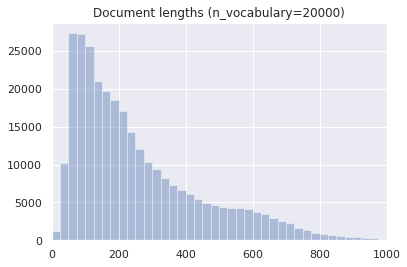

In [26]:
n_sequence = 512

sequences = tokenizer.texts_to_sequences(docs)
sequence_lengths = [len(s) for s in sequences]
if n_sequence is None:
    n_sequence = max(sequence_lengths)
sequences = pad_sequences(sequences,
                          maxlen=n_sequence,
                          padding="post",
                          truncating="post")

print(n_sequence)
print(sequences.shape)
print(sequences[2])

sns.distplot(sequence_lengths, bins=np.arange(0, 1000, 25), kde=False)
plt.title(f"Document lengths (n_vocabulary={n_vocabulary})")
plt.xlim(0, 1000)
plt.show()

### As document-term matrix

In [27]:
# doc_term_matrix = tokenizer.texts_to_matrix(docs, mode="tfidf")

# print(doc_term_matrix.shape)
# print(doc_term_matrix[2])

## Word embeddings

In [28]:
n_embedding = 300

### Word2Vec

In [29]:
# reset_seed()

# window = 5
# w2v_path = f"data/w2v_{window}_{n_embedding}.model"

# try:
#     embedding_model = Word2Vec.load(w2v_path)
# except:
#     embedding_model = Word2Vec(sentences=[s.split() for s in docs],
#                                size=n_embedding, 
#                                window=window,
#                                min_count=5,
#                                sg=1,
#                                workers=cpu_count(),
#                                seed=seed)
#     embedding_model.save(w2v_path)

# print(len(list(embedding_model.wv.vocab)))

### FastText

In [30]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:])))
    return data

embedding_model = load_vectors("data/wiki-news-300d-1M.vec")

### Creating embedding matrix

In [31]:
embedding_matrix = np.zeros((n_vocabulary, n_embedding))
for token, i in word_idx.items():
    if i >= n_vocabulary:
        continue
    if token in embedding_model:
        embedding_matrix[i] = embedding_model[token]
    else:
        embedding_matrix[i] = np.zeros(n_embedding)

print(embedding_matrix.shape)
print(embedding_matrix[1])

(20000, 300)
[ 8.970e-02  1.600e-02 -5.710e-02  4.050e-02 -6.960e-02 -1.237e-01
  3.010e-02  2.480e-02 -3.030e-02  1.740e-02  6.300e-03  1.840e-02
  2.170e-02 -2.570e-02  3.500e-02 -2.420e-02  2.900e-03  1.880e-02
 -5.700e-02  2.520e-02 -2.100e-02 -8.000e-04  3.600e-02 -7.290e-02
 -6.650e-02  9.890e-02  6.760e-02  8.520e-02 -8.900e-03  3.130e-02
 -6.900e-03 -3.200e-03 -4.620e-02  4.970e-02  2.610e-02  2.680e-02
 -3.100e-02 -1.361e-01 -6.200e-03  3.750e-02 -3.200e-02 -1.060e-02
  5.340e-02 -1.870e-02  6.380e-02  9.400e-03  4.700e-03 -5.300e-02
  9.300e-03 -8.700e-03  4.000e-04  4.930e-02 -6.296e-01  2.220e-02
  1.900e-02  2.680e-02 -4.260e-02  5.700e-03 -1.683e-01  2.440e-02
 -2.130e-02 -1.810e-02  4.210e-02 -3.090e-02 -8.900e-03  3.200e-03
  1.080e-02 -4.900e-03  2.580e-02  2.780e-02 -1.630e-02  2.000e-02
  1.640e-02 -9.540e-02 -3.200e-03  4.300e-03  1.040e-02 -8.800e-03
  7.000e-04  3.500e-02 -2.060e-02 -8.300e-03 -1.140e-02 -1.869e-01
  2.580e-02  1.000e-03  8.500e-03  1.510e-02  2.1

## Defining the NN model

In [32]:
def init_model():
#     with MirroredStrategy().scope():
        model = Sequential()

#         model.add(Embedding(input_dim=n_vocabulary,
#                             output_dim=n_embedding,
#                             input_length=n_sequence))
#         model.add(Dropout(.25))

        model.add(Embedding(
            input_dim=n_vocabulary,
            output_dim=n_embedding,
            embeddings_initializer=Constant(embedding_matrix),
            input_length=n_sequence,
            trainable=False
        ))

#         model.add(Conv1D(128, 5, activation="relu"))
#         model.add(MaxPooling1D(5))
#         model.add(Conv1D(128, 5, activation="relu"))
#         model.add(MaxPooling1D(5))
#         model.add(Conv1D(128, 5, activation="relu"))
#         model.add(GlobalMaxPooling1D())
#         model.add(Dense(128, activation="relu"))

#         model.add(Conv1D(64, 5, activation="relu"))
#         model.add(Dropout(.25))
#         model.add(Conv1D(128, 5, activation="relu"))
#         model.add(Dropout(.25))
#         model.add(Flatten())
#         model.add(Dense(128))
#         model.add(BatchNormalization())
#         model.add(ReLU())
#         model.add(Dropout(.25))
#         model.add(Dense(128))
#         model.add(BatchNormalization())
#         model.add(ReLU())
#         model.add(Dropout(.25))

        model.add(GRU(128, dropout=.2))
        model.add(Dense(128, activation="relu"))
        model.add(Dropout(.2))

#         model.add(LSTM(128, dropout=.2))
#         model.add(Dense(128, activation="relu"))
#         model.add(Dropout(.2))

#         model.add(Bidirectional(LSTM(256, return_sequences=True)))
#         model.add(Bidirectional(LSTM(128)))
#         model.add(Dense(128, activation="relu"))
#         model.add(Dropout(.5))

#         model.add(Dense(128, activation="relu", input_shape=(n_vocabulary,)))
#         model.add(Dropout(.5))

        model.add(Dense(n_labels, activation="sigmoid"))
        model.compile(loss="binary_crossentropy", optimizer="adam")
        return model

init_model().summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 512, 300)          6000000   
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               165120    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 126)               16254     
Total params: 6,197,886
Trainable params: 197,886
Non-trainable params: 6,000,000
_________________________________________________________________


## Preparing the data

In [33]:
n_samples = None
x_train, y_train = shuffle(sequences,
                           train_labels,
                           random_state=seed,
                           n_samples=n_samples)

## Cross-evaluating the model

In [34]:
reset_seed()

kfold = KFold(n_splits=5)
cv_scores = []
batch_size = 256

for train, val in kfold.split(x_train, y_train):
    model = init_model()
    es = EarlyStopping(patience=3, verbose=1, restore_best_weights=True)
    history = model.fit(x_train[train],
                        y_train[train],
                        batch_size=batch_size,
                        epochs=100,
                        verbose=1,
                        validation_data=(x_train[val], y_train[val]),
                        callbacks=[es])
    
    y_pred_prob = model.predict(x_train[val], batch_size=batch_size, verbose=1)
    y_pred = np.round(y_pred_prob)
    
    scores = {}
    scores["accuracy"] = accuracy_score(y_train[val], y_pred)
    scores["F1 (macro)"] = f1_score(y_train[val], y_pred, average="macro")
    scores["F1 (micro)"] = f1_score(y_train[val], y_pred, average="micro")
    scores["LRAP"] = label_ranking_average_precision_score(y_train[val],
                                                           y_pred_prob)
    scores["NDCG"] = ndcg_score(y_train[val], y_pred_prob)
    cv_scores.append(scores)
    print(scores)
    
cv_scores_df = pd.DataFrame(cv_scores)

Epoch 1/100
937/937 [==============================] - 61s 65ms/step - loss: 0.0793 - val_loss: 0.0388
Epoch 2/100
937/937 [==============================] - 60s 64ms/step - loss: 0.0332 - val_loss: 0.0261
Epoch 3/100
937/937 [==============================] - 60s 64ms/step - loss: 0.0260 - val_loss: 0.0225
Epoch 4/100
937/937 [==============================] - 60s 64ms/step - loss: 0.0231 - val_loss: 0.0208
Epoch 5/100
937/937 [==============================] - 60s 65ms/step - loss: 0.0214 - val_loss: 0.0195
Epoch 6/100
937/937 [==============================] - 61s 65ms/step - loss: 0.0202 - val_loss: 0.0186
Epoch 7/100
937/937 [==============================] - 61s 65ms/step - loss: 0.0194 - val_loss: 0.0181
Epoch 8/100
937/937 [==============================] - 60s 65ms/step - loss: 0.0188 - val_loss: 0.0176
Epoch 9/100
937/937 [==============================] - 61s 65ms/step - loss: 0.0182 - val_loss: 0.0174
Epoch 10/100
937/937 [==============================] - 61s 65ms/step - l

KeyboardInterrupt: 

## Metrics and their means

In [ ]:
display(cv_scores_df)
print(cv_scores_df.mean())